In [1]:
%matplotlib inline

# Visualize Single Cell Data Using Segmentation Results
This tutorial shows how to utilize segmentation results to conduct downstream single cell analysis. The single-cell analysis part requires popularly used packages scanpy and anndata.

Here we use 10x Xenium DCIS data as an example. We mainly focus on how the segmentation results can be used for downstream single-cell analysis. The steps of model training are skipped and more details can be accessed from xxx.

### Import packages & data

In [2]:
import sys 
import random
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt 

sys.path.append('/data/aronow/Kang/spatial/Bering/cosmx')
import BeringNodeToLink_v3 as br

After the model is trained, we can use the trained model to predict the cell types and segment all spots on the whole slice. After node classification and cell segmentation is completed, we generate single cell matrix in the end.

### load pretrained model

In [3]:
import pickle
with open('/data/aronow/Kang/spatial/Bering/demo/tutorials/plotting/models/Xenium_dcis_model_simplified.pl', 'rb') as f:
    bg = pickle.load(f)

### Get single cell data from whole slice
In the function br.tl.cell_annotation, we generate two single cell data, including one from direct prediction result, and the other from ensembl annotations of the prediction. More details can be found in the function description.

In [4]:
br.tl.node_classification(bg, bg.spots_all.copy(), n_neighbors = 30)
br.tl.cell_segmentation(bg)
df_results, adata_ensembl, adata_segmented = br.tl.cell_annotation(bg)

print(adata_segmented.shape)
print(adata_segmented.obs.head())
print(adata_ensembl.shape)
print(adata_ensembl.obs.head())

                     x          y          z features  segmented   labels  \
molecule_id                                                                 
0            2100.0261  2350.3684  19.269732      LUM          0  Stromal   
1            2100.2126  2178.9346  18.475246   HAVCR2          1  Stromal   
2            2100.3599  2261.9116  20.490784    RUNX1          2  Stromal   
3            2100.3918  2155.2341  20.006990     TCIM          3  Stromal   
4            2100.5117  2353.7695  20.749512    CXCR4          4  B_Cells   

                groups predicted_node_labels  predicted_probability  \
molecule_id                                                           
0            segmented               Stromal               0.863927   
1            segmented         Macrophages_2               0.326667   
2            segmented               Stromal               0.899313   
3            segmented               Stromal               0.667508   
4            segmented            

### Single cell data analysis

In [5]:
# define function for single cell analysis from raw count matrix
import scanpy as sc

def sc_analysis(adata):
    sc.pp.filter_cells(adata, min_counts = 10)
    sc.pp.normalize_total(adata, target_sum = 1e3)
    sc.pp.log1p(adata)
    sc.pp.scale(adata) # the number of features is less than 1000, so we don't use variable genes here

    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors = 10)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    
    # plot Bering results and Leiden clustering
    columns = ['predicted_labels','leiden','n_counts','n_genes'] if 'predicted_labels' in adata.obs.columns else ['leiden','n_counts','n_genes']
    sc.pl.umap(adata, color = columns)

2023-07-03 17:20:19.840255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 17:20:20.690205: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


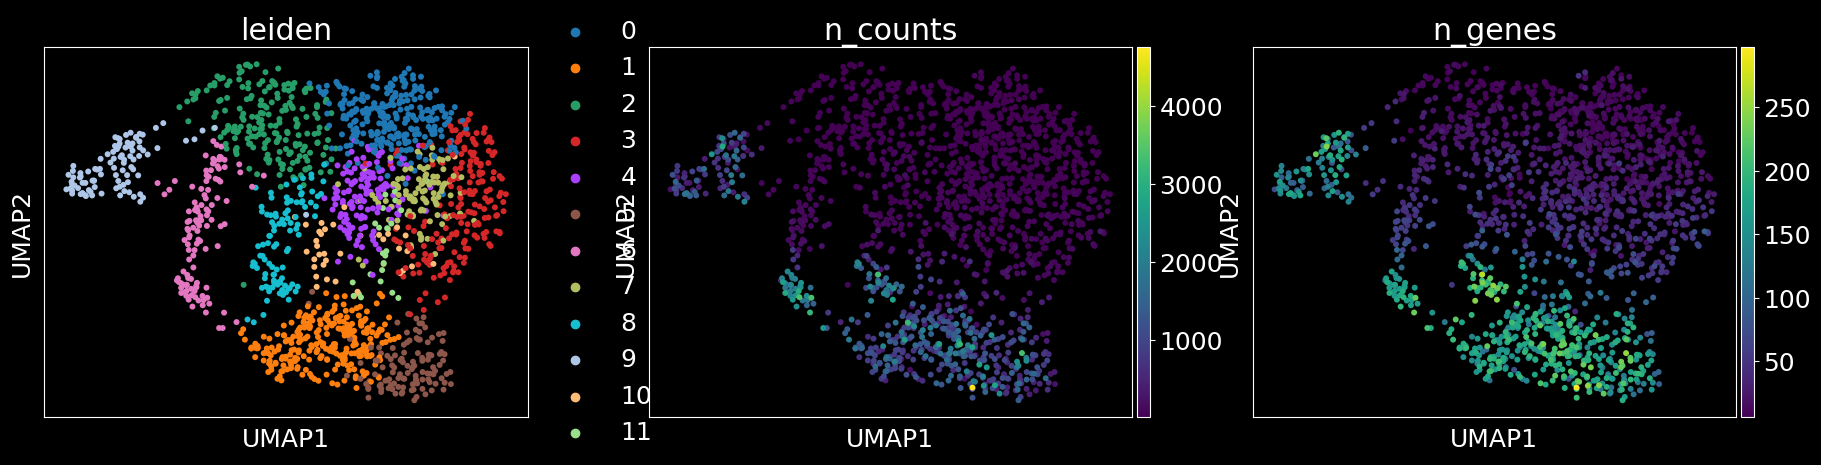

In [6]:
# analysis of segmented cells without ensembl annotations
sc_analysis(adata_segmented)

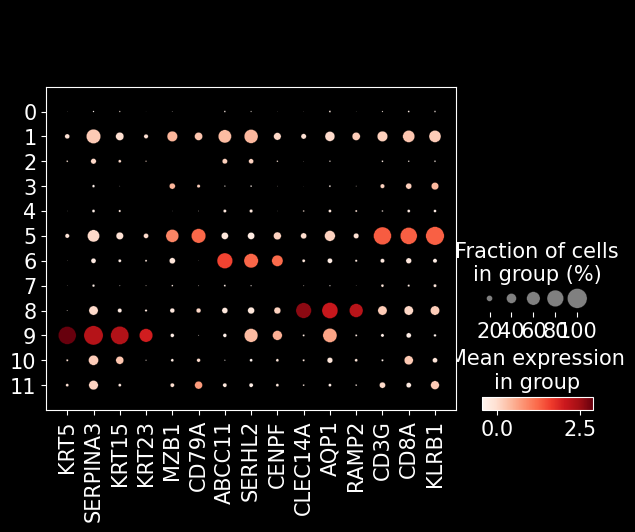

In [7]:
marker_genes = [
    'KRT5', 'SERPINA3', 'KRT15', 'KRT23', # tumor
    'MZB1', 'CD79A', # pDC
    'ABCC11', 'SERHL2', 'CENPF', # epithelial
    'CLEC14A', 'AQP1', 'RAMP2', # endothelial
    'CD3G', 'CD8A', 'KLRB1', # T cell
]
sc.pl.dotplot(adata_segmented, marker_genes, groupby = 'leiden')

... storing 'predicted_labels' as categorical


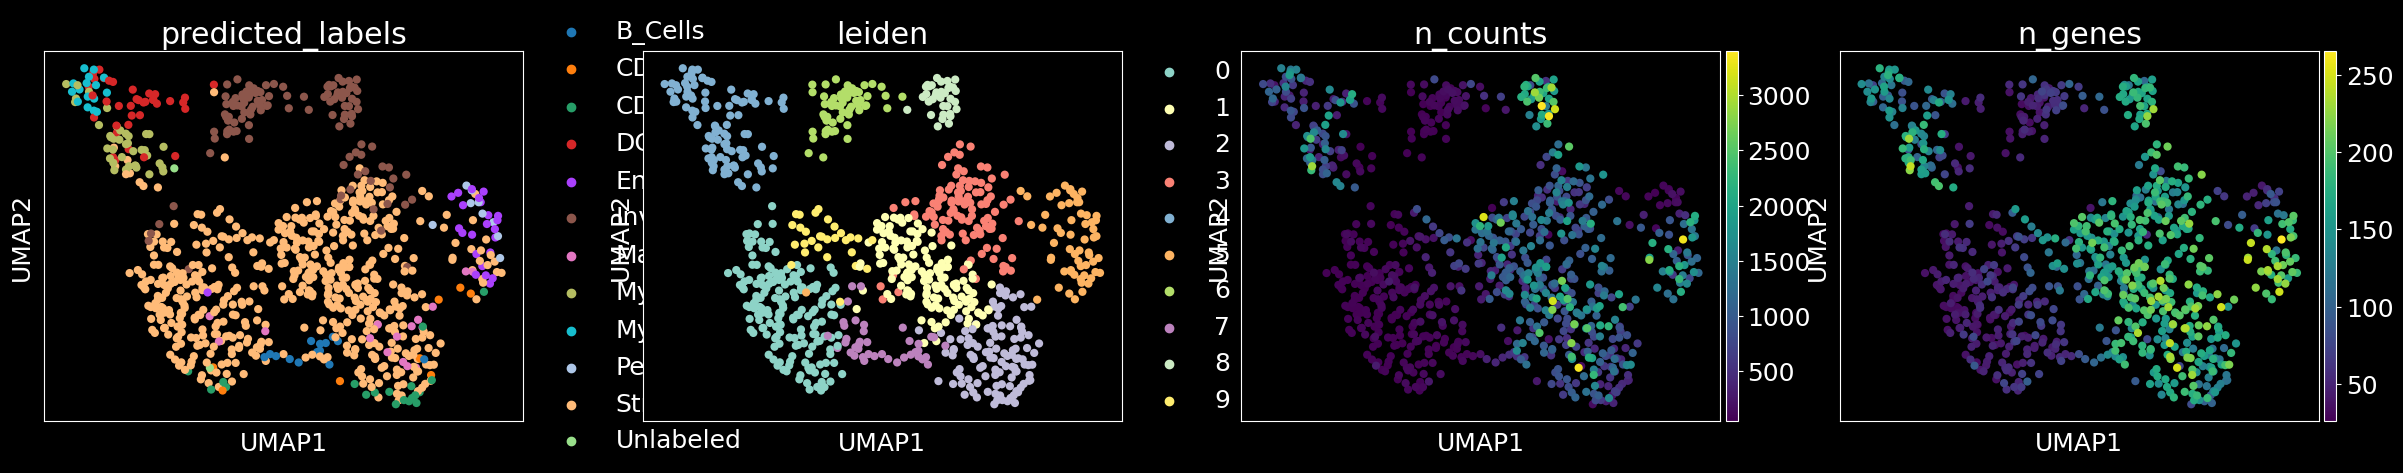

In [8]:
# analysis of segmented cells with ensembl annotations
sc_analysis(adata_ensembl)

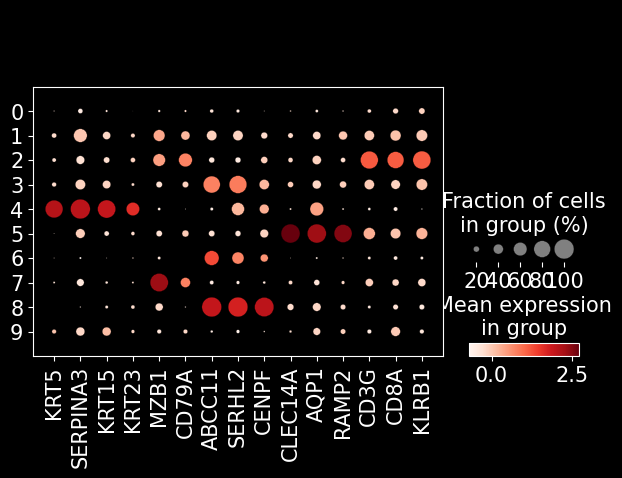

In [9]:
sc.pl.dotplot(adata_ensembl, marker_genes, groupby = 'leiden')

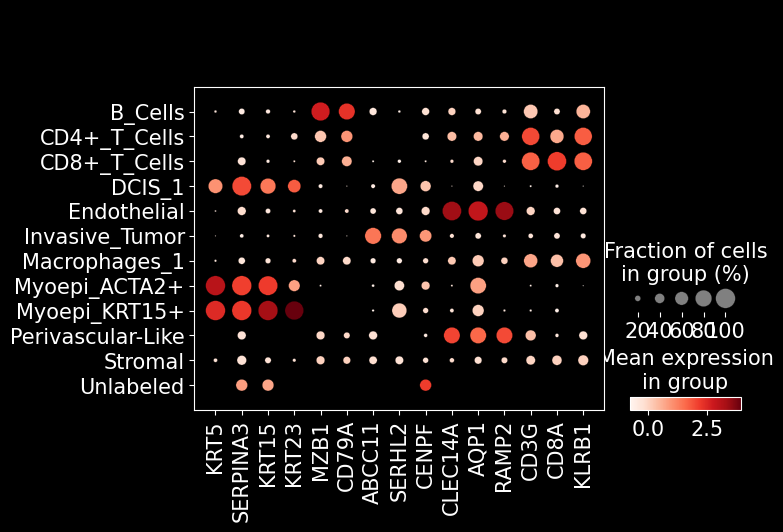

In [10]:
sc.pl.dotplot(adata_ensembl, marker_genes, groupby = 'predicted_labels')